# Understanding Attention and Implementing It

> If we are providing a huge dataset to the model to learn, it is possible that a few important parts of the data might be ignored by the models. Paying attention to important information is necessary and it can improve the performance of the model. This can be achieved by adding an additional attention feature to the models. Neural networks built using different layers can easily incorporate this feature through one of the layers. We can use the attention layer in its architecture to improve its performance. 

* We can categorize the attention mechanism into the following ways:

1. Self-Attention
2. Global/Soft
3. Local/Hard

### Self-Attention

> When an attention mechanism is applied to the network so that it can relate to different positions of a single sequence and can compute the representation of the same sequence, it can be considered as self-attention and it can also be known as intra-attention. 

<center><img src = 'https://149695847.v2.pressablecdn.com/wp-content/uploads/2021/12/image-13.png'></center>

> Here in the image, the red color represents the word which is currently learning and the blue color is of the memory, and the intensity of the color represents the degree of memory activation. 

### Soft/Global Attention Mechanism:

> When the attention applied in the network is to learn, every patch or sequence of the data can be called a Soft/global attention mechanism. This attention can be used in the field of image processing and language processing.

### Local/Hard Attention Mechanism:

> when the attention mechanism is applied to some patches or sequences of the data, it can be considered as the Local/Hard attention mechanism. This type of attention is mainly applied to the network working with the image processing task. 

<center><img src = 'https://149695847.v2.pressablecdn.com/wp-content/uploads/2021/12/image-14.png' width = 700></center>


### Import Section

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,Attention,Input,Concatenate
from keras.datasets import imdb 
from tensorflow.keras import Model
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler,ReduceLROnPlateau,TensorBoard
import datetime
from math import sqrt
#!pip install keras-tuner 
import os
#import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.utils import plot_model

## Lets pull imdb dataset

In [2]:
n_unique_words = 10000 # cut texts after this number of words
batch_size = 128 
(X_train, y_train),(X_test, y_test) = imdb.load_data(num_words=n_unique_words) 


17464789/17464789 [==============================] - 0s 0us/step


## Lets understand the statistics of word length of the IMDB reviews

100%|██████████| 25000/25000 [00:00<00:00, 835039.66it/s]


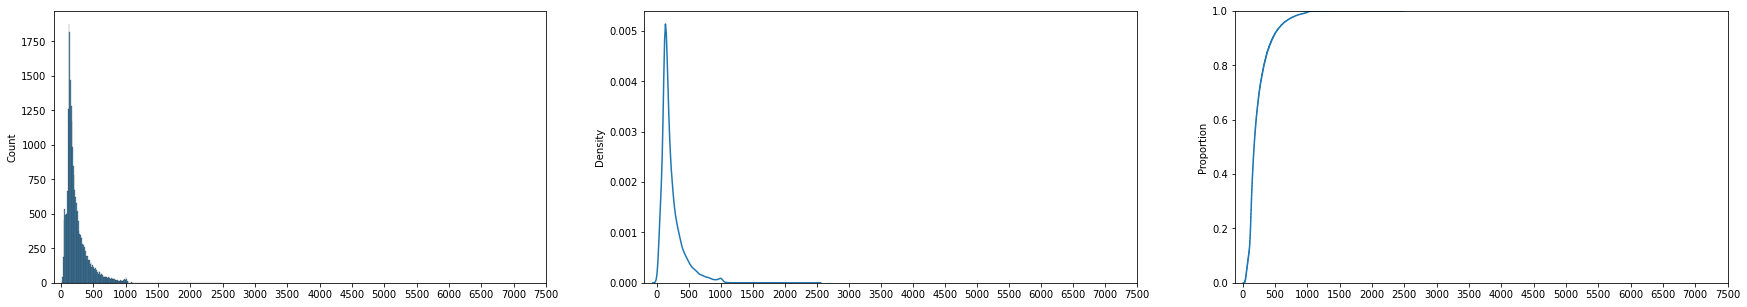

In [3]:
train_review_lengths = []
for review in tqdm(X_train):
  train_review_lengths.append(len(review))
fig, axs = plt.subplots(ncols=3,figsize=(30,5))
a = sns.histplot(data = train_review_lengths,ax=axs[0])
a.set_xticks(range(0,8000,500))
b = sns.kdeplot(data = train_review_lengths,ax=axs[1])
b.set_xticks(range(0,8000,500))
c = sns.ecdfplot(data = train_review_lengths,ax=axs[2])
c.set_xticks(range(0,8000,500))
plt.show()


In [4]:
maxlen = 1000
X_train = pad_sequences(X_train, maxlen=maxlen,padding='post',truncating='post')
X_test = pad_sequences(X_test, maxlen=maxlen,padding='post',truncating='post')
y_train = np.array(y_train)
y_test = np.array(y_test)

In [5]:
y_train

array([1, 0, 0, ..., 0, 1, 0])

## Lets build a model with attention and bi directional lstms

In [6]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [22]:
tf.keras.backend.clear_session()
batch_size = 128
inp = Input(shape=(maxlen,), dtype='int32')
embed_out = Embedding(n_unique_words, 300,input_length=maxlen)(inp)
bidirectional_1_out = Bidirectional(LSTM(units = 150,activation='tanh',kernel_initializer = 'he_normal',return_sequences = True,return_state = True))(embed_out)
bidirectional_2_out,forward_h,forward_c,backward_h,backward_c = Bidirectional(LSTM(units = 150,activation='tanh',kernel_initializer = 'he_normal',return_sequences = True,return_state = True))(bidirectional_1_out)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
context_vector, attention_weights = Attention(32)(bidirectional_2_out, state_h)
dense_1_out = Dense(150, activation = 'relu', kernel_initializer = 'he_normal')(context_vector)
dropout_1 = Dropout(0.7)(dense_1_out)
out = Dense(1, activation = 'sigmoid')(dropout_1)
model = Model(inputs = inp, outputs = out)
#printing the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1000, 300)    3000000     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  [(None, 1000, 300),  541200      ['embedding[0][0]']              
                                 (None, 150),                                                     
                                 (None, 150),                                                     
                                 (None, 150),                                                 

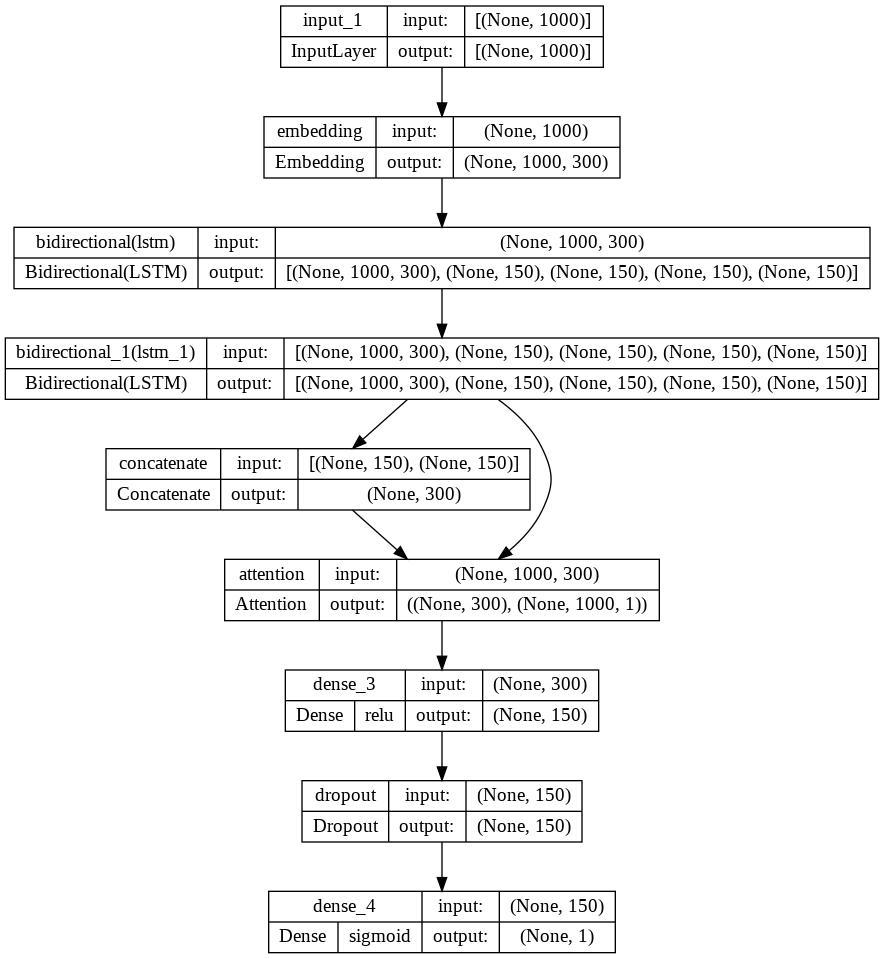

In [23]:
plot_model(model,show_shapes=True,show_layer_activations = True)

In [12]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [13]:
filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [14]:
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3, verbose=1)

In [15]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
%reload_ext tensorboard

In [16]:
history = model.fit(X_train,y_train,epochs=10, batch_size=200,validation_split=.3, verbose=1, callbacks=[checkpoint,earlystop,tensorboard_callback])

Epoch 1/10
88/88 [==============================] - ETA: 0s - loss: 0.4497 - accuracy: 0.7613
Epoch 1: val_accuracy improved from -inf to 0.86987, saving model to model_save/weights-01-0.8699.hdf5
88/88 [==============================] - 85s 890ms/step - loss: 0.4497 - accuracy: 0.7613 - val_loss: 0.3128 - val_accuracy: 0.8699
Epoch 2/10
88/88 [==============================] - ETA: 0s - loss: 0.2058 - accuracy: 0.9248
Epoch 2: val_accuracy improved from 0.86987 to 0.89267, saving model to model_save/weights-02-0.8927.hdf5
88/88 [==============================] - 77s 871ms/step - loss: 0.2058 - accuracy: 0.9248 - val_loss: 0.2686 - val_accuracy: 0.8927
Epoch 3/10
88/88 [==============================] - ETA: 0s - loss: 0.1217 - accuracy: 0.9587
Epoch 3: val_accuracy did not improve from 0.89267
88/88 [==============================] - 76s 869ms/step - loss: 0.1217 - accuracy: 0.9587 - val_loss: 0.3514 - val_accuracy: 0.8807
Epoch 4/10
88/88 [==============================] - ETA: 0s - 

In [17]:
model.load_weights('/content/model_save/weights-02-0.8927.hdf5')

In [19]:
result = model.evaluate(X_test, y_test)
print(result)

782/782 [==============================] - 60s 77ms/step - loss: 0.2945 - accuracy: 0.8805
[0.2944532334804535, 0.8804799914360046]
